In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import numpy as np
download('punkt')
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import graphviz

[nltk_data] Downloading package punkt to /Users/mjn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
def nlp_preprocess(doc_string):
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer() 
    
    tokens = word_tokenize(doc_string)
    remove_punct = [word.lower() for word in tokens if word.isalnum()]
    remove_stops = [word for word in remove_punct if word not in stopwords_english]
    stemmed = [stemmer.stem(word) for word in remove_stops]

    return stemmed


def vocabulary_dict(tokens_list):
    idx = 0
    vocab = {}
    for word in tokens_list:
        if word not in vocab.keys():
            vocab.update({word: idx})
            idx += 1
            
    return vocab


def tokens_to_vector(tokens, vocabulary):
    vector = np.zeros((1,len(vocabulary.keys())))
    for word in tokens:
        if word in vocabulary.keys():
            vector[0, int(vocabulary[word])] = 1
    
    return vector


def df_to_raw_string(research_df):
    raw_str = ""
    for row in research_df.iterrows():
        row_tup = (row[1]['CBInsightsDescription'], row[1]['QuidDescription'], row[1]['CrunchbaseDescription'])
        raw_str += " ".join(row_tup)
        
    return raw_str


def df_to_array(research_df, vocabulary):
    m = research_df.shape[0]
    n = len(vocabulary.keys())
    data_array = np.zeros((m, n))
    idx = 0
    for row in research_df.iterrows():
        raw_str = ""
        row_tup = (row[1]['CBInsightsDescription'], row[1]['QuidDescription'], row[1]['CrunchbaseDescription'])
        raw_str += " ".join(row_tup)
        tokens = nlp_preprocess(raw_str)
        vect = tokens_to_vector(tokens, vocabulary)
        data_array[idx] = vect
        idx += 1

    return data_array

def plot_loss_multiclass(results_dict, output_path='log-loss.jpg', show_plot=False):    
    epochs = len(results_dict['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot log loss
    fig = plt.figure(figsize=(7,5))
    plt.plot(x_axis, results_dict['validation_0']['mlogloss'], label='Train')
    plt.plot(x_axis, results_dict['validation_1']['mlogloss'], label='Test')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Epochs')
    plt.title('Log-Loss')
    plt.savefig(output_path)
    if show_plot==True:
        plt.show()
    
def plot_error_multiclass(results_dict, output_path='classification-error.jpg', show_plot=False):        
    # plot classification error
    epochs = len(results_dict['validation_0']['merror'])
    x_axis = range(0, epochs)
    # plot error
    fig = plt.figure(figsize=(7,5))
    plt.plot(x_axis, results_dict['validation_0']['merror'], label='Train')
    plt.plot(x_axis, results_dict['validation_1']['merror'], label='Test')
    plt.legend()
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.title('Classification Error')
    plt.savefig(output_path)
    if show_plot==True:
        plt.show()

def plot_feature_importance(fitted_model, output_path='feature-importance.jpg', 
                            top_n_features=10,  show_plot=False):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10))
    xgb.plot_importance(fitted_model, max_num_features=top_n_features, 
                        importance_type="weight", ax=ax[0], title="Importance: Weight")
    xgb.plot_importance(fitted_model, max_num_features=top_n_features,
                        importance_type="gain", ax=ax[1], title="Importance: Gain")
    xgb.plot_importance(fitted_model, max_num_features=top_n_features,
                        importance_type="cover", ax=ax[2],  title="Importance: Cover")
    plt.savefig(output_path)
    if show_plot==True:
        plt.show()

def plot_confusion_matrix(confusionmatrix, fitted_model, 
                          output_path='confusion-matrix.jpg', show_plot=False):
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=confusionmatrix, 
                                     display_labels=fitted_model.classes_)
    fig, ax = plt.subplots(figsize=(8,10))
    cm_plot.plot(ax=ax)
    plt.savefig(output_path)
    if show_plot==True:
        cm_plot.show()
        
        
def token_from_index(vocab_dict, index_value):
    key_list = list(vocab_dict.keys())
    val_list = list(vocab_dict.values())
    
    return key_list[index_value]

In [4]:
# load data, asign classes, concatenate

addit_df = pd.read_csv('../../data/additive-manufacturing-advanced-materials.csv')
addit_df['class'] = "robotics-vehicles-defense"
agric_df = pd.read_csv('../../data/agricultural-technology.csv')
agric_df['class'] = "agricultural-technology"
artif_df = pd.read_csv('../../data/artificial-intelligence-machine-learning.csv')
artif_df['class'] = "ai-cyber-data"
augme_df = pd.read_csv('../../data/augmented-reality-mixed-reality.csv')
augme_df['class'] = "ai-cyber-data"
auton_df = pd.read_csv('../../data/autonomous-systems.csv')
auton_df['class'] = "robotics-vehicles-defense"
biote_df = pd.read_csv('../../data/biotechnology-pharmaceuticals.csv')
biote_df['class'] = "biotechnology-pharmaceuticals"
consu_df = pd.read_csv('../../data/consulting-market-research.csv')
consu_df['class'] = "consulting-marketing"
consm_df = pd.read_csv('../../data/consumer-products-services.csv')
consm_df['class'] = "consulting-marketing"
cyber_df = pd.read_csv('../../data/cybersecurity.csv')
cyber_df['class'] = "ai-cyber-data"
analy_df = pd.read_csv('../../data/data-analytics-it-software.csv')
analy_df['class'] = "ai-cyber-data"
educa_df = pd.read_csv('../../data/education-training-professional-development.csv')
educa_df['class'] = "consulting-marketing"
elect_df = pd.read_csv('../../data/electronics-microelectronics-hardware.csv')
elect_df['class'] = "electronics-microelectronics"
energ_df = pd.read_csv('../../data/energy-power.csv')
energ_df['class'] = "electronics-microelectronics"
healt_df = pd.read_csv('../../data/healthcare-human-systems.csv')
healt_df['class'] = "biotechnology-pharmaceuticals"
indus_df = pd.read_csv('../../data/industrial-manufacturing.csv')
indus_df['class'] = "manufacturing-logistics"
intel_df = pd.read_csv('../../data/intelligence-surveillance.csv')
intel_df['class'] = "robotics-vehicles-defense"
logis_df = pd.read_csv('../../data/logistics-distribution.csv')
logis_df['class'] = "manufacturing-logistics"
marke_df = pd.read_csv('../../data/marketing-media.csv')
marke_df['class'] = "consulting-marketing"
model_df = pd.read_csv('../../data/modeling-simulation.csv')
model_df['class'] = "ai-cyber-data"
posit_df = pd.read_csv('../../data/position-navigation.csv')
posit_df['class'] = "robotics-vehicles-defense"
robot_df = pd.read_csv('../../data/robotics-mechatronics.csv')
robot_df['class'] = "robotics-vehicles-defense"
space_df = pd.read_csv('../../data/space-aerospace-technology.csv')
space_df['class'] = "robotics-vehicles-defense"
telec_df = pd.read_csv('../../data/telecommunication-systems-services.csv')
telec_df['class'] = "ai-cyber-data"
vehic_df = pd.read_csv('../../data/vehicle-systems.csv')
vehic_df['class'] = "robotics-vehicles-defense"

#all
corpus_df = pd.concat([addit_df, agric_df, artif_df, augme_df, auton_df, 
                       biote_df, consu_df, consm_df, cyber_df, analy_df, 
                       educa_df, elect_df, energ_df, healt_df, indus_df,
                       intel_df, logis_df, marke_df, model_df, posit_df,
                       robot_df, space_df, telec_df, vehic_df], 
                      axis=0, ignore_index=True)
#health, robotics
#corpus_df = pd.concat([health_df, robotics_df], 
#                      axis=0, ignore_index=True)

#ai, modeling
#corpus_df = pd.concat([aiml_df, modeling_df], 
#                      axis=0, ignore_index=True)

print("Train/ Test examples: " + str(corpus_df.shape[0]))

Train/ Test examples: 1479


In [5]:
# process text
raw_str = df_to_raw_string(corpus_df)
tokens = nlp_preprocess(raw_str)
vocab = vocabulary_dict(tokens)
print("Total tokens: " + str(len(tokens)))
print("Unique tokens: " + str(len(vocab.keys())))

Total tokens: 141530
Unique tokens: 9605


In [6]:
# data arrays
X = df_to_array(corpus_df, vocab)
Y = corpus_df['class'].values

In [7]:
# encode Y labels
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)
a = [print(label) for label in label_encoder.classes_]

agricultural-technology
ai-cyber-data
biotechnology-pharmaceuticals
consulting-marketing
electronics-microelectronics
manufacturing-logistics
robotics-vehicles-defense


In [8]:
# split data into train and test sets
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=test_size)
print("Training examples: " + str(len(y_train)))
print("Testing examples: " + str(len(y_test)))

Training examples: 1257
Testing examples: 222


In [9]:
# fit model to training data
eval_metrics = ['merror', 'mlogloss']
eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBClassifier(objective="multi:softmax", learning_rate=0.1, max_depth=100, n_estimators=1000)
#model.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_set, verbose=False)
model.fit(X_train, y_train, eval_metric=eval_metrics, eval_set=eval_set, early_stopping_rounds=100, verbose=False)
results = model.evals_result()

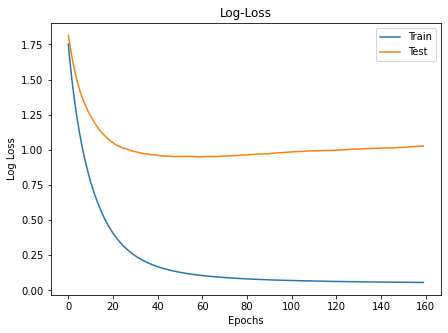

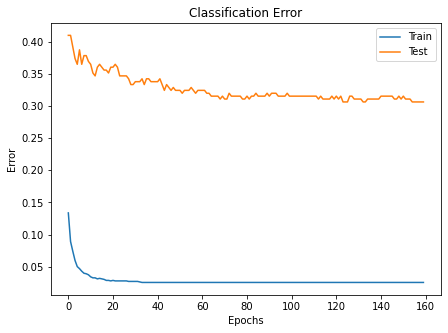

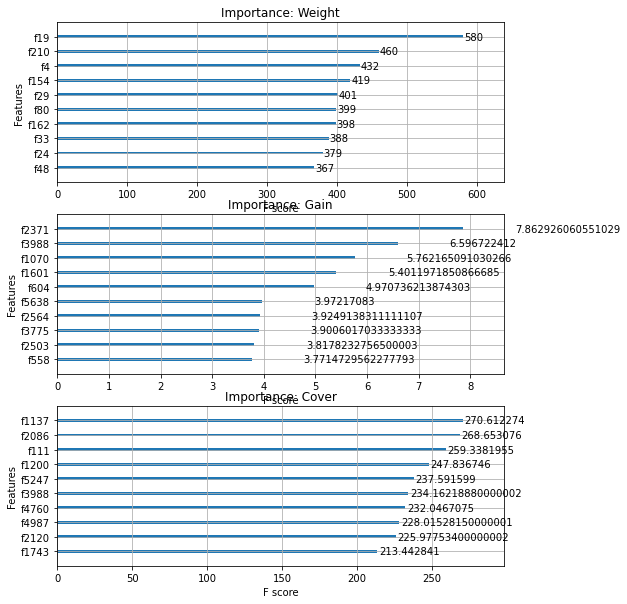

In [10]:
plot_loss_multiclass(results, output_path="mc-log-loss.jpg", show_plot=False)
plot_error_multiclass(results, output_path="mc-error.jpg", show_plot=False)
plot_feature_importance(model, output_path="mc-important-features.jpg", show_plot=False)

In [11]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [12]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.57%


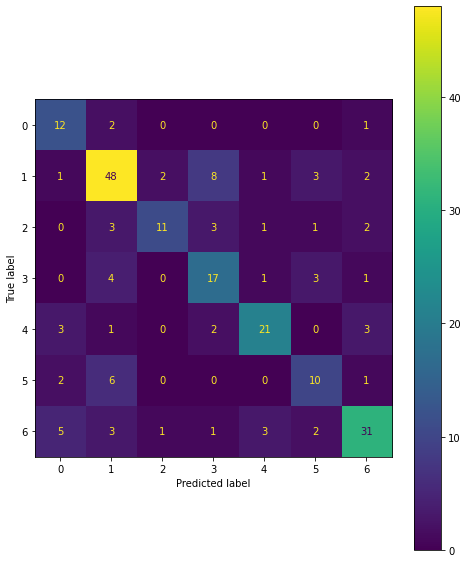

In [45]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
plot_confusion_matrix(cm, model)

* 0: agricultural-technology
* 1: ai-cyber-data
* 2: biotechnology-pharmaceuticals
* 3: consulting-marketing
* 4: electronics-microelectronics
* 5: manufacturing-logistics
* 6: robotics-vehicles-defense

## Second Front Systems

In [46]:
pred_str = "Second Front Systems is a public benefit, venture-backed company that \
equips defense and national security professionals for long-term, continuous competition \
for access to emerging technologies. To accelerate the delivery of emerging technologies \
to U.S. and Allied warfighters.  To enable enduring strategic advantage for the U.S. and \
its allies through agile, responsive acquisition warfare. While serving in the U.S. Marine \
Corps, our co-founders Peter Dixon and Mark Butler saw firsthand the damages done by an \
outdated acquisition system to those on the frontlines of defending our country. To address \
this critical issue, they formed Second Front Systems as a public benefit corporation with \
the mission of accelerating the transition of technology to U.S. and Allied warfighters. \
Our team is comprised of trailblazers dedicated to bridging the gap between the government and private sector."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 54.0
Class: ai-cyber-data


## Prescient Edge

In [47]:
pred_str = "Prescient Edge is a veteran-owned small business that was founded as a Counterintelligence \
and Human Intelligence company in 2008. Prescient Edge counterintelligence subject matter experts \
perform a critical function in counterintelligence investigations and operations, pursuant to and \
in accordance with applicable Department of Defense Directives and Instructions."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 22.0
Class: consulting-marketing


## Bayer-Monsanto

In [48]:
pred_str = "Agricultural innovation means better solutions and greater choice for farmers and consumers \
around the world. Through our tailored solutions, like seeds and traits, crop protection, and digital tools, \
we’re offering farmers better answers to meet the specific needs of their farms, all while preserving the \
environment. Bringing together our expertise, we’re using our unique position as an agricultural leader \
to deliver innovation that helps farmers grow more sustainably and responsibly. Every crop, field, and \
farmer is different. Each has their own needs, challenges, and goals. In our effort to truly benefit \
farmers, consumers, and the planet, we believe it is our responsibility to ensure that our innovations \
are accessible to people all over the world. At Bayer, we aim to empower farmers, helping them to achieve \
their best harvest each growing season and to foster sustainable, reliable growth for their businesses and \
communities. As we work to ensure bountiful harvests today, we’re committed to leaving the planet in better \
shape for tomorrow."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 71.0
Class: agricultural-technology


## Primer.ai

In [49]:
pred_str = "Primer enables organizations to quickly explore and utilize the world’s exponentially \
growing sources of text-based information. Our best-in-class natural language processing (NLP) \
engines and applications help you make sense of it all in real-time with human-level precision. \
Request a demo to learn more about: Primer Engines — assemble data processing pipelines with flexible \
building blocks pretrained on domain-specific data. Primer Automate — build your own NLP models, or \
retrain Primer Engines on your own data, with no technical skills required. Primer Analyze — create a \
scalable, self-curating knowledge base that can sift through billions of documents in seconds. \
Primer Extract — explore large caches of data quickly with translation, OCR, and image recognition capabilities. \
UNLOCK MACHINE INTELLIGENCE. Primer provides industrial-grade NLP applications for government agencies, \
financial institutions, Fortune 50 companies, and many other organizations. Organizations collect massive \
amounts of data — far more than human analysts can handle. As a result, much of it remains unexplored or \
underutilized. At Primer, we are dedicated to helping organizations make the best use of their investment in \
data. We do this by using best-in-class machine learning and natural language processing technologies to help \
our customers scale and optimize their intelligence workflows."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 82.0
Class: ai-cyber-data


## Teton Telecom

In [50]:
pred_str ="Who Is Teton Telecom? What We Offer  Mergers and Acquisitions Fractional Executive Service Mergers \
and Acquisitions Fiber Optics Fractional Executive Service Mergers and Acquisitions Fractional Executive \
Service Fractional Executive Service Fractional Executive Service Comprehensive Business Services Comprehensive \
Business Services Comprehensive Business Services Stakeholder Communications and Investor Relations \
Comprehensive Business Services Comprehensive Business Services Underwriting Adding Value Comprehensive \
Business Services Adding Value Social Contact Us Contact Us Help us help you! Let us know the details on \
your project, or whatever it is you're hoping to accomplish. We'll let you know if it's something we can \
help with. We look forward to hearing from you! Teton Telecom Get in Touch  apply. GoDadd"
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 36.0
Class: consulting-marketing


## Moderna

In [51]:
pred_str = "Every cell in the body uses mRNA to provide real-time instructions to make the proteins \
necessary to drive all aspects of biology, including in human health and disease. Given its essential \
role, we believe mRNA could be used to create a new category of medicines with significant potential \
to improve the lives of patients. We are pioneering a new class of medicines made of messenger RNA, \
or mRNA. The potential implications of using mRNA as a drug are significant and far-reaching and could \
meaningfully improve how medicines are discovered, developed and manufactured. Since our founding in \
2010, we have worked to build the industry's leading mRNA technology platform, the infrastructure to \
accelerate drug discovery and early development, a rapidly expanding pipeline, and a world-class team. \
Our pipeline includes development candidates for mRNA-based vaccines and therapies spanning several \
therapeutic areas, and we have multiple clinical trials underway with other development candidates \
progressing toward the clinic. In addition, we have numerous discovery programs advancing toward \
development.  Moderna's Mission: Deliver on the promise of mRNA science to create a new generation \
of transformative medicines for patients."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 80.0
Class: biotechnology-pharmaceuticals


## Anduril

In [52]:
pred_str = "Anduril builds cutting-edge hardware and software products that solve complex national \
security challenges for America and its allies. At the core of all our products is Lattice, an AI \
software backbone that uses sensor fusion, machine learning, and mesh networking to integrate \
real-time data from Anduril hardware and third-party systems into a single, autonomous operating picture. \
Software Lattice Platform Artificial intelligence At the core of all our products is Lattice, an AI \
software backbone that uses sensor fusion, machine learning, and mesh networking to integrate real-time \
data from Anduril hardware and third-party systems into a single, autonomous operating picture. Hardware \
Sentry Tower Autonomous awareness Sentry towers are equipped with the latest sensors and work together \
via Lattice to augment awareness in remote locations. With a compact footprint, hardened onboard processing \
and solar power architecture, Sentry can be rapidly deployed and sustained with minimal maintenance in \
austere conditions. Hardware Ghost 4 sUAS Intelligent air support Ghost 4 is an autonomous VTOL sUAS that \
operates on the Lattice AI platform. Ghost 4 is modular, man-portable, waterproof, and combines long \
endurance, high payload capacity and a near-silent acoustic signature for a wide variety of mission \
capabilities. Hardware Anvil sUAS Precision kinetic intercept Anvil is the kinetic element of our \
end-to-end cUAS capability. It uses physical speed and onboard guidance to seek and destroy drone \
threats with positive identification and minimal collateral damage. Mission Effective Anduril is a \
product company developing technology that works from day one. We deploy in hours, not years. Our \
partners start receiving actionable intelligence within minutes of activation."
tokens = nlp_preprocess(pred_str)
vect = tokens_to_vector(tokens, vocab)
print("Vocabulary matches: " + str(vect.sum()))
pred = model.predict(vect)
pred_class = label_encoder.inverse_transform(pred)
print('Class: ' + pred_class[0])

Vocabulary matches: 106.0
Class: robotics-vehicles-defense
